# Time Series EDA

- Time Series Train-Test Split
    1. Human-based
    1. Percentage Based
    1. Cross Validate Splits
- 10 Weird Time Series Visualizations to Impress Your Friends and Family (Doctors Hate Her)
    1. Blow off the time series
    1. y over time
    1. y averaged over various periods over time
    1. change in y over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
- Aside: working with dates in matplotlib
- Aside: `strftime`

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

url = 'https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
df.head()

df.shape[0]

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


45252

- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Train-Test Split

- Ideally all splits contain a season
- Human-based: use the last year as test
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)
    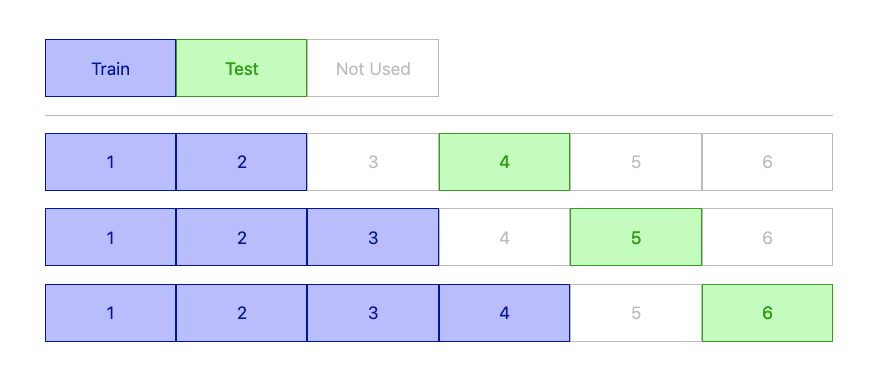

In [2]:
# Percentage-Based
train_size = 0.70
n = df.shape[0]
test_start_index = round(train_size*n)

In [3]:
test_start_index

31676

In [4]:
train = df[:test_start_index]
test = df[test_start_index:]

In [5]:
# Human-Based
train = df.loc[:'2016']
test = df.loc['2017':]

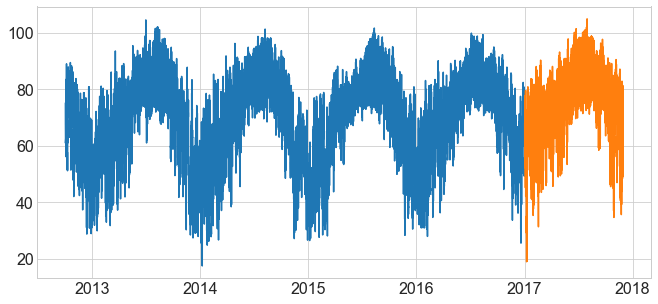

In [6]:
plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)
plt.show()

## Visualizations

In [7]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

### 1 Blow off the time series

<AxesSubplot:ylabel='Frequency'>

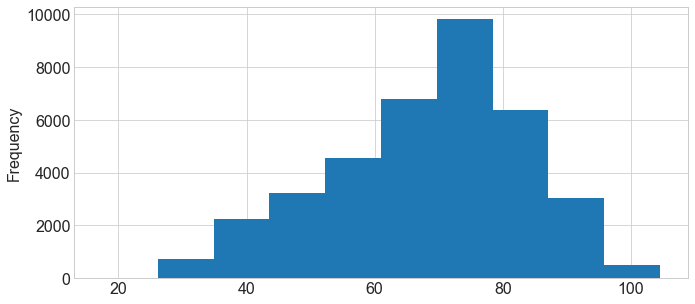

In [8]:
train.temp.plot.hist()

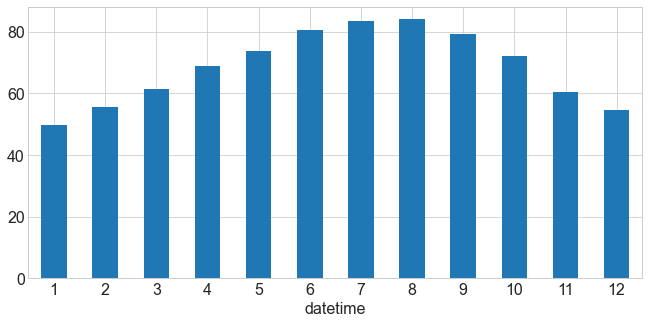

In [9]:
train.groupby(train.index.month).temp.mean().plot.bar().tick_params('x', rotation=0)

In [10]:
train['weekday'] = train.index.day_name()

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_81613/455270753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.day_name()


<AxesSubplot:xlabel='weekday'>

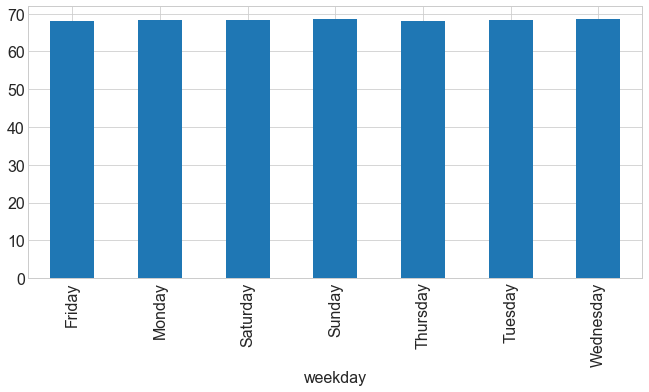

In [11]:
train.groupby('weekday').temp.mean().plot.bar()

<AxesSubplot:xlabel='weekday', ylabel='temp'>

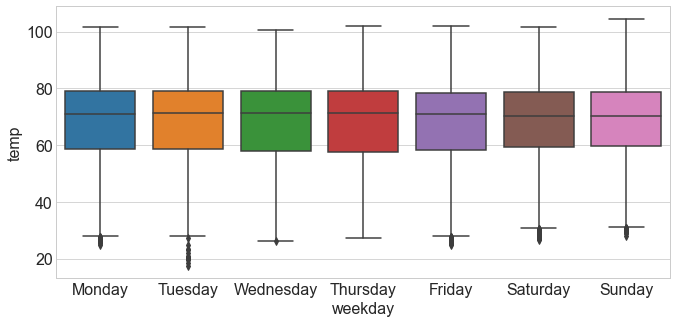

In [12]:
sns.boxplot(data=train, y='temp', x='weekday')

### 2 y over time

<AxesSubplot:xlabel='datetime'>

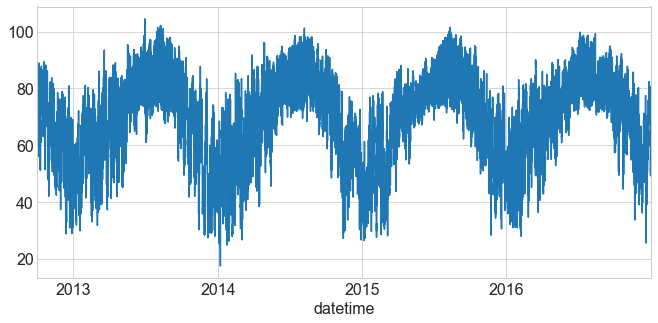

In [13]:
y.plot()

### 3 y averaged over various periods over time

<AxesSubplot:xlabel='datetime'>

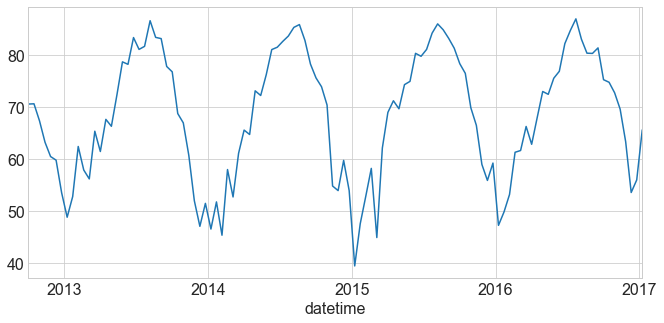

In [14]:
y.resample('2W').mean().plot()

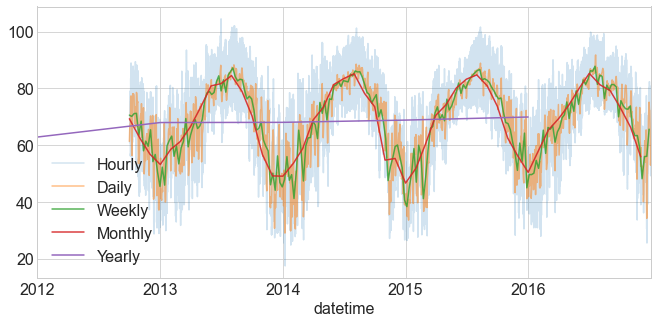

In [15]:
y.plot(alpha=0.2, label='Hourly')
y.resample('D').mean().plot(alpha=0.5, label='Daily')
y.resample('W').mean().plot(alpha=0.8, label='Weekly')
y.resample('M').mean().plot(alpha=0.9, label='Monthly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()
plt.show()

### 4 change in y over time

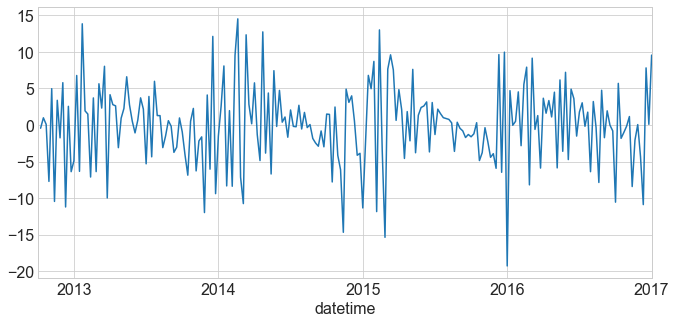

In [16]:
y.resample('W').mean().diff().plot()
plt.show()

[Text(0.5, 1.0, 'Temp over Time')]

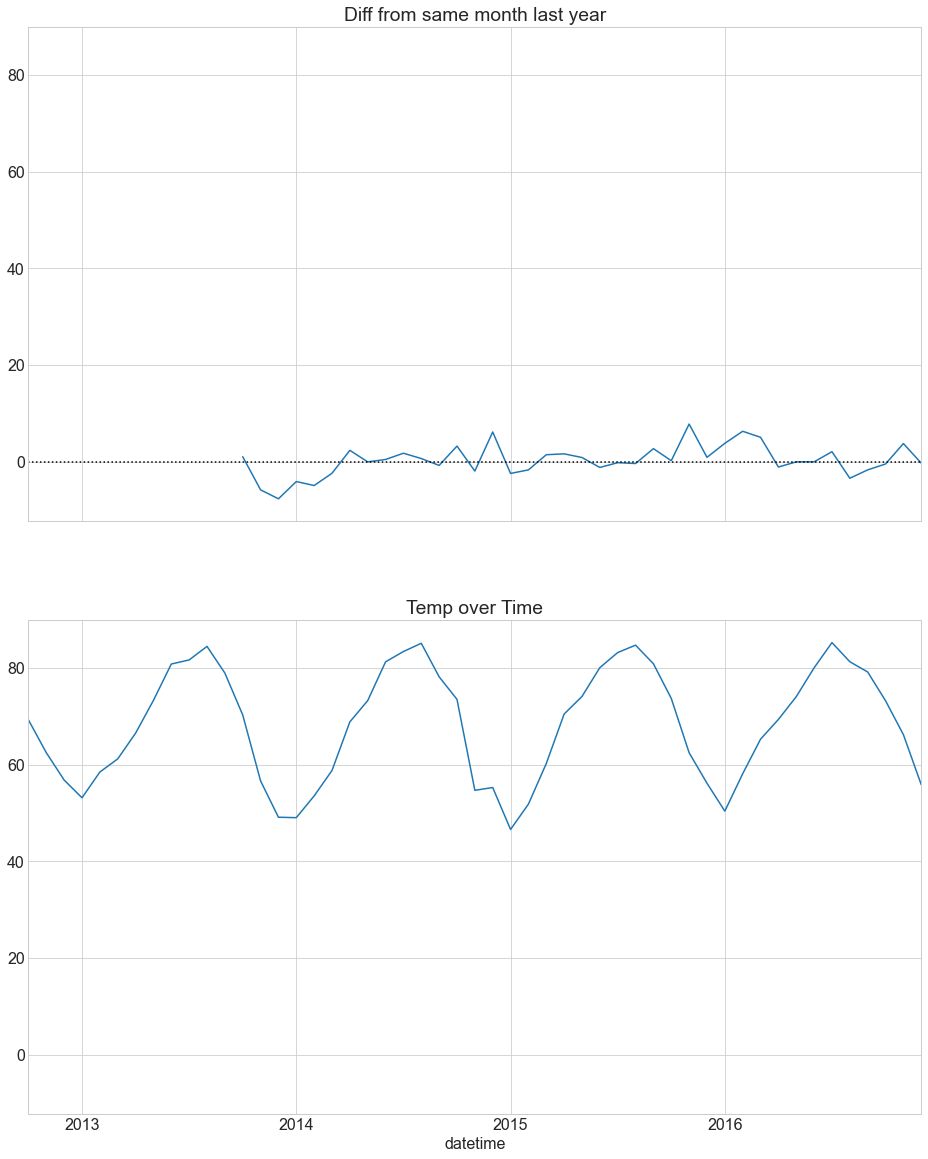

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,20))

y.resample('M').mean().diff(12).plot(ax=ax1)
ax1.hlines(0,*ax1.get_xlim(), color='black', ls=':')
ax1.set(title='Diff from same month last year')

y.resample('M').mean().plot(ax=ax2)
ax2.set(title='Temp over Time')

### 5 Seasonal Plot

- xaxis: month 
- yaxis: y
- color: year

In [18]:
y.groupby([y.index.year, y.index.month]).mean()[:3]

datetime  datetime
2012      10          69.318705
          11          62.521575
          12          56.860014
Name: temp, dtype: float64

In [19]:
y.groupby([y.index.year, y.index.month]).mean().unstack()

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.318705,62.521575,56.860014
2013,53.192333,58.522799,61.244479,66.569717,73.358529,80.885728,81.731819,84.534117,79.016805,70.343832,56.686028,49.165310
2014,49.072897,53.579080,58.842459,68.908933,73.311970,81.337658,83.476876,85.178102,78.238621,73.567252,54.735951,55.311824
2015,46.631940,51.874683,60.277705,70.526879,74.169747,80.135967,83.264325,84.789859,80.938208,73.766466,62.519181,56.207118
2016,50.427347,58.165749,65.323011,69.415316,74.129780,80.097570,85.325640,81.357023,79.233476,73.284788,66.265047,55.903224


In [20]:
stack = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

In [21]:
stack

datetime,2012,2013,2014,2015,2016
datetime,,,,,
1,NaN,53.192333,49.072897,46.631940,50.427347
2,NaN,58.522799,53.579080,51.874683,58.165749
3,NaN,61.244479,58.842459,60.277705,65.323011
4,NaN,66.569717,68.908933,70.526879,69.415316
5,NaN,73.358529,73.311970,74.169747,74.129780
6,NaN,80.885728,81.337658,80.135967,80.097570
7,NaN,81.731819,83.476876,83.264325,85.325640
8,NaN,84.534117,85.178102,84.789859,81.357023
9,NaN,79.016805,78.238621,80.938208,79.233476


<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='datetime'>

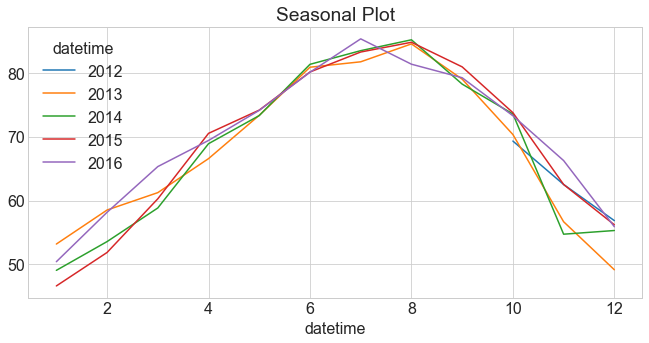

In [22]:
stack.plot(title='Seasonal Plot')

### 6 Seasonal Subseries Plot

In [23]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

In [24]:
table

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.318705,62.521575,56.860014
2013,53.192333,58.522799,61.244479,66.569717,73.358529,80.885728,81.731819,84.534117,79.016805,70.343832,56.686028,49.165310
2014,49.072897,53.579080,58.842459,68.908933,73.311970,81.337658,83.476876,85.178102,78.238621,73.567252,54.735951,55.311824
2015,46.631940,51.874683,60.277705,70.526879,74.169747,80.135967,83.264325,84.789859,80.938208,73.766466,62.519181,56.207118
2016,50.427347,58.165749,65.323011,69.415316,74.129780,80.097570,85.325640,81.357023,79.233476,73.284788,66.265047,55.903224


In [25]:
# for month_number, subset in table.items():
#     print(month_number)
#     print(subset)

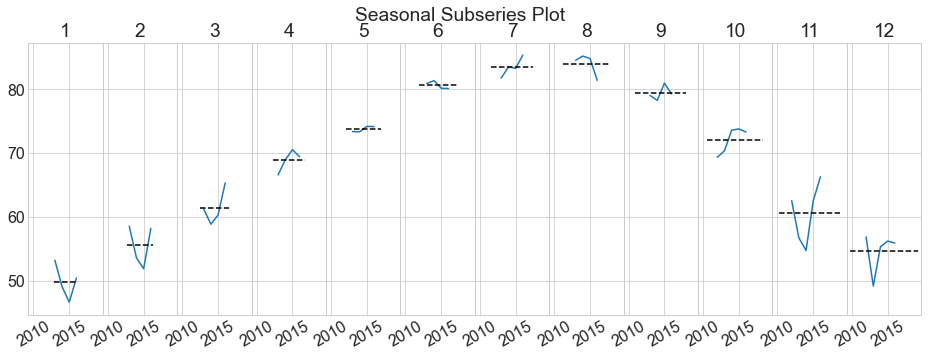

In [28]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(16, 5))

for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), color='black', ls='--')
    ax.set(xlabel='')
    ax.tick_params('x', rotation=30)
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
# fig.tight_layout()
fig.subplots_adjust(wspace=0)

### 7 Lag Plot

In [29]:
train['y(t+1)'] = train.temp.shift(-1)

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_81613/1741490057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y(t+1)'] = train.temp.shift(-1)


In [30]:
train.head()

,temp,weekday,y(t+1)
datetime,,,
2012-10-01 13:00:00,61.052000,Monday,61.076568
2012-10-01 14:00:00,61.076568,Monday,61.139294
2012-10-01 15:00:00,61.139294,Monday,61.202020
2012-10-01 16:00:00,61.202020,Monday,61.264747
2012-10-01 17:00:00,61.264747,Monday,61.327473


[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

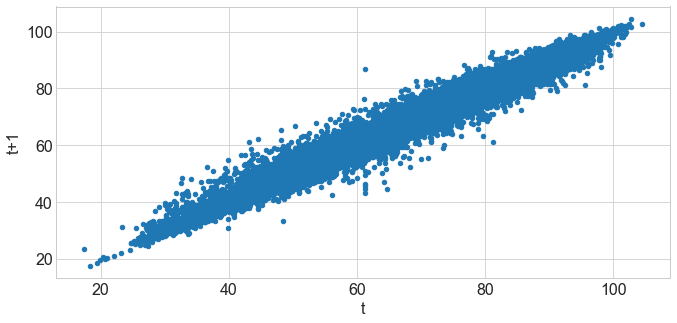

In [31]:
train.plot.scatter(x='temp', y='y(t+1)').set(xlabel='t', ylabel='t+1')

In [32]:
weekly = train.resample('W').mean().drop(columns='y(t+1)')
weekly['next_week'] = weekly.temp.shift(-1)

In [34]:
weekly = weekly.rename(columns={'temp':'this_week'})

<AxesSubplot:xlabel='this_week', ylabel='next_week'>

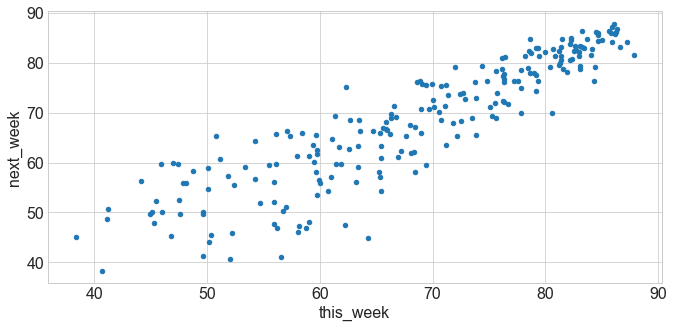

In [35]:
weekly.plot.scatter(x='this_week', y='next_week')

<AxesSubplot:xlabel='this_week', ylabel='12_weeks'>

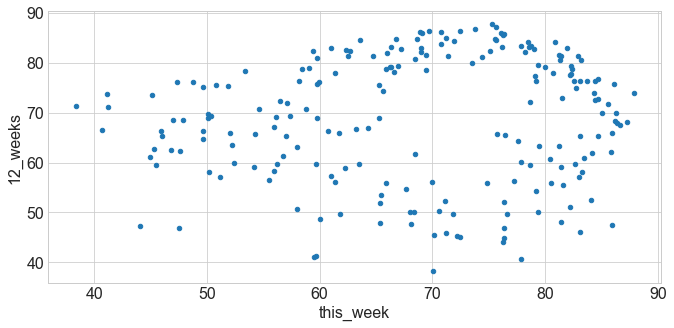

In [36]:
weekly = train.resample('W').mean().drop(columns='y(t+1)')
weekly['12_weeks'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp':'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

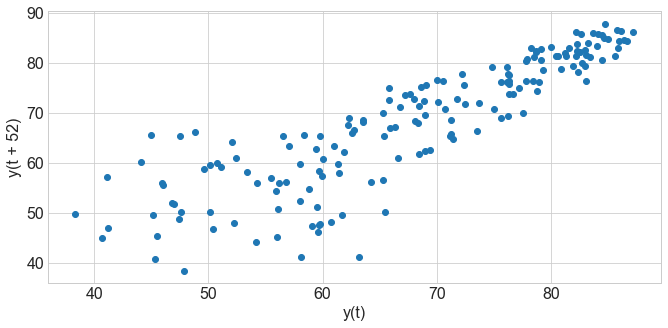

In [37]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=52)

### 8 Autocorrelation Plot

- What is pearson's r as a function of the lag time?
- **autocorrelation**: a series correlation with itself
- can help to identify seasonality

In [38]:
weekly.columns

Index(['this_week', '12_weeks'], dtype='object')

In [39]:
lag = 1
weekly.this_week.iloc[:-lag].shape, weekly.this_week.shift(-lag).dropna().shape

((221,), (221,))

In [45]:
weekly = train.resample('W').mean()
s=pd.Series({
        lag: stats.pearsonr(
            weekly.temp.iloc[:-lag], weekly.temp.shift(-lag).dropna())[0]
        for lag in range(1, 52*3 +1)
})

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

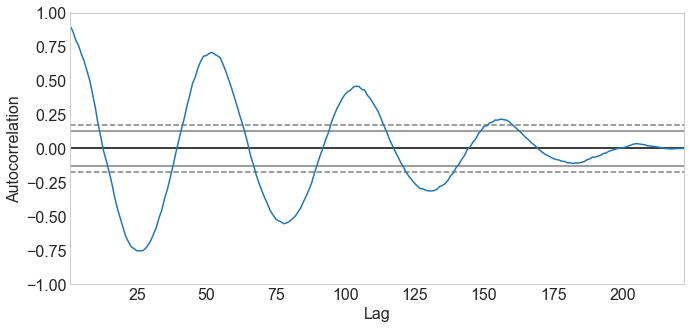

In [46]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

### 9 Seasonal Decomposition

In [50]:
y = train.temp.resample('W').mean()
result = sm.tsa.seasonal_decompose(y)

In [51]:
decomposition = pd.DataFrame({
            'y' : result.observed,
            'trend' : result.trend,
            'seasonal' : result.seasonal,
            'resid' : result.resid
})

In [52]:
decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()

<AxesSubplot:xlabel='datetime'>

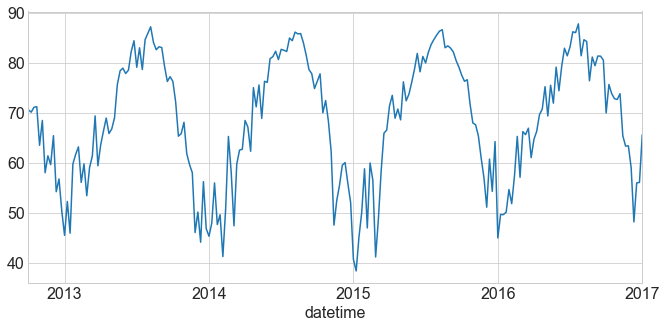

In [56]:
decomposition.y.plot()

<AxesSubplot:xlabel='datetime'>

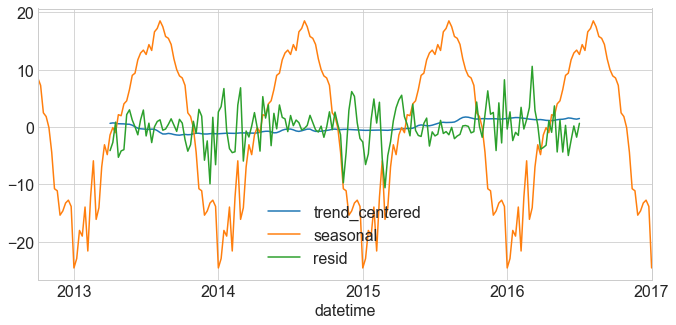

In [68]:
decomposition[['trend_centered','seasonal','resid']].plot()

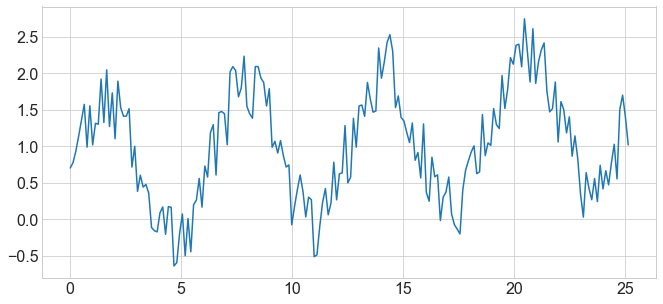

In [66]:
# Simulation Demo
import numpy as np

x = np.linspace(0, 8 * np.pi, 200)
seasonal = np.sin(x)
trend = np.linspace(0, 1, 200)
resid = np.random.rand(200)

y = seasonal + trend + resid

plt.plot(x, y)

### 10 Area Plots

- can we visualize categories over time?

In [69]:
train.columns

Index(['temp', 'weekday', 'y(t+1)'], dtype='object')

In [70]:
train = train.drop(columns='y(t+1)')
train = train.resample('D').mean()

In [71]:
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold','cool','warm','hot'])

In [72]:
train.head()

,temp,temp_bin
datetime,,
2012-10-01,61.330942,cool
2012-10-02,65.678822,cool
2012-10-03,67.411250,cool
2012-10-04,67.703750,cool
2012-10-05,77.073125,warm


In [73]:
train.groupby('temp_bin').resample('M').size()

temp_bin  datetime  
cold      2012-10-31     6
          2012-11-30    10
          2012-12-31    16
          2013-01-31    24
          2013-02-28    17
                        ..
hot       2016-06-30    19
          2016-07-31    28
          2016-08-31    21
          2016-09-30    18
          2016-10-31     5
Length: 195, dtype: int64

How is the distribution of temp_bin changing over time?

In [74]:
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,49.381699
cool,65.200219
warm,75.447977
hot,83.449087


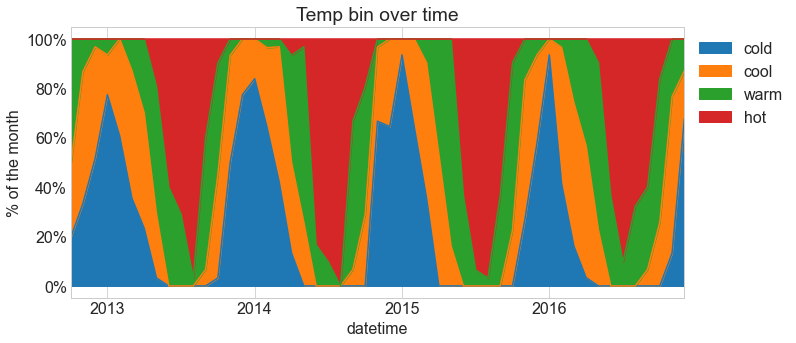

In [75]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area(title='Temp bin over time', ylabel='% of the month'))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter('{:.0%}'.format)

## `strftime`

[Cheatsheet](https://zgulde.net/strftime.html) or `man strftime`

In [80]:
train.index.strftime('%w-%A')

Index(['1-Monday', '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday',
       '6-Saturday', '0-Sunday', '1-Monday', '2-Tuesday', '3-Wednesday',
       ...
       '4-Thursday', '5-Friday', '6-Saturday', '0-Sunday', '1-Monday',
       '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday', '6-Saturday'],
      dtype='object', name='datetime', length=1553)

In [81]:
df.head(5).index.strftime('The date is %B %d, %Y and the time is %I:%M %p')

Index(['The date is October 01, 2012 and the time is 01:00 PM',
       'The date is October 01, 2012 and the time is 02:00 PM',
       'The date is October 01, 2012 and the time is 03:00 PM',
       'The date is October 01, 2012 and the time is 04:00 PM',
       'The date is October 01, 2012 and the time is 05:00 PM'],
      dtype='object', name='datetime')

See also: pd.Categorical

## Matplotlib Dates

In [76]:
from matplotlib.dates import DateFormatter, MonthLocator

In [77]:
weekly = df.temp.resample('W').mean()

<AxesSubplot:xlabel='datetime'>

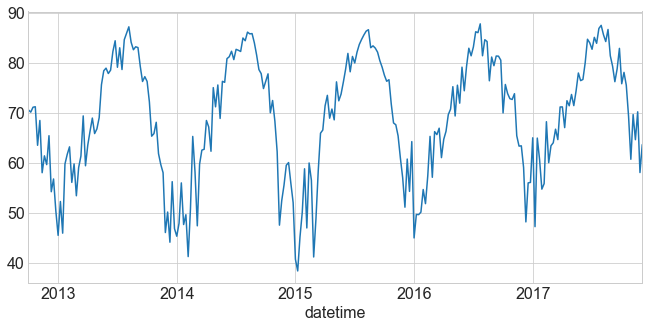

In [78]:
weekly.plot()

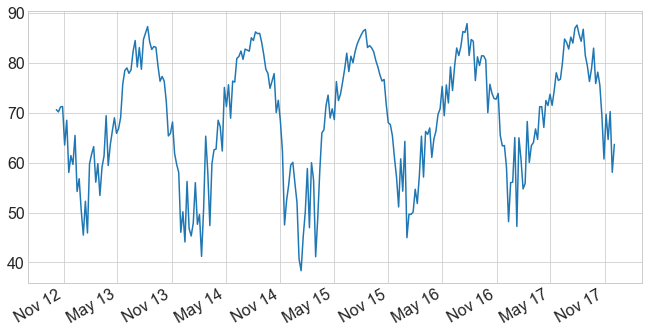

In [79]:
fig, ax = plt.subplots()

x = weekly.index
y = weekly.values

ax.plot(x, y)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_major_locator(MonthLocator(interval=6))

ax.tick_params(axis='x', rotation=30)

for tick in ax.xaxis.get_majorticklabels():
    tick.set_ha('right')